In [1]:
!nvidia-smi

Mon Feb 28 17:45:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     Off  | 00000000:37:00.0 Off |                  Off |
| 80%   87C    P2   268W / 260W |  43114MiB / 48601MiB |     92%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:86:00.0 Off |                  Off |
| 33%   

In [2]:
import pandas as pd

from data import build_dataset
from transformers import AutoTokenizer

PRETRAINED_MODEL = 'allenai/longformer-large-4096'

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

train, test = pd.read_csv('gutenberg-long_train.csv').sample(frac=1), pd.read_csv('gutenberg-long_test.csv')
in_train = train.groupby('author').apply(len)[(train.groupby('author').apply(len) >= 2)].index
in_test = test.groupby('author').apply(len)[(test.groupby('author').apply(len) >= 2)].index

train_data = build_dataset(train[train.author.isin(in_train)], tokenizer, steps=len(train), batch_size=64, max_len=4096)
test_data = build_dataset(test[test.author.isin(in_test)], tokenizer, steps=5000, batch_size=100, num_workers=2, prefetch_factor=2, max_len=4096)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
from transformers import AutoModel

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning import Trainer

from datetime import datetime
from model import ContrastivePretrain, ContrastivePretrainDense

import wandb

date_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

print("date and time:",date_time)

MIN_TRAIN_STEPS = 10000
LR = 5e-3
DECAY = .01
WARMUP_STEPS = 1000

SAVE_NAME = f'{date_time}_frozen-longformer_NCEPretrain'

wandb.login()

wandb_logger = WandbLogger(name=SAVE_NAME, project="author_profiling")

checkpoint_callback = ModelCheckpoint('model',
                                      filename=SAVE_NAME,
                                      monitor=None,
                                      every_n_val_epochs=1,
                                     )
    
#early_stop_callback = EarlyStopping(monitor="valid/loss", min_delta=1e-8, patience=10, verbose=True, mode="min")
lr_monitor = LearningRateMonitor('step')

trainer = Trainer(devices=[1],
                  accumulate_grad_batches=8,
                  max_steps=MIN_TRAIN_STEPS,
                  accelerator='gpu',
                  log_every_n_steps=1,
                  flush_logs_every_n_steps=500,
                  logger=wandb_logger,
                  strategy='dp',
                  precision=16,
                  val_check_interval=500,
                  callbacks=[checkpoint_callback, lr_monitor],
                 )

base_transformer = AutoModel.from_pretrained(PRETRAINED_MODEL)

train_model = ContrastivePretrain(base_transformer,
                                  learning_rate=LR,
                                  weight_decay=DECAY,
                                  num_warmup_steps=WARMUP_STEPS,
                                  num_training_steps=MIN_TRAIN_STEPS)

trainer.fit(train_model, train_data, test_data)
wandb.finish()

date and time: 2022-02-28_17-46-05


wandb: Currently logged in as: jahuerta92 (use `wandb login --relogin` to force relogin)
/home/jhuertas/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:237: LightningDeprecationWarning: `ModelCheckpoint(every_n_val_epochs)` is deprecated in v1.4 and will be removed in v1.6. Please use `every_n_epochs` instead.
  rank_zero_deprecation(
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/jhuertas/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:59: LightningDeprecationWarning: Setting `Trainer(flush_logs_every_n_steps=500)` is deprecated in v1.5 and will be removed in v1.7. Please configure flushing in the logger instead.
  rank_zero_deprecation(
Some weights of the model checkpoint at allenai/longformer-large-4096 were not used when initializing LongformerModel: ['lm_head.layer_nor


  | Name        | Type            | Params
------------------------------------------------
0 | transformer | LongformerModel | 434 M 
1 | pooler      | DynamicLSTM     | 6.3 M 
------------------------------------------------
6.3 M     Trainable params
434 M     Non-trainable params
440 M     Total params
881.801   Total estimated model params size (MB)
/home/jhuertas/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/jhuertas/work/notebooks/author_profiling/model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/home/jhuertas/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/jhuertas/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


epoch,▁
linear_schedule_with_warmup,▁▁▁▁▁▁▁▁█████
train/infonce_acc,▁
train/infonce_loss,▁
trainer/global_step,▁▁▁▁▁▁▁▁▁█████
epoch,0
linear_schedule_with_warmup,1e-05
train/infonce_acc,0.01562
train/infonce_loss,4.15695
trainer/global_step,1


In [ ]:
def predict(model, data, batch=128, dev=1):
    embeds = []
    data = data.groupby('user_id').apply(lambda x: '\n'.join(x.text.tolist())).tolist()
    encoded = tokenizer(data, return_tensors='pt', max_length=512, truncation=True)
    
    with torch.no_grad():
        for i in range(0, len(data), batch):
                embeds.append(model(encoded.input_ids[i:i+batch].cuda(dev), encoded.attention_mask[i:i+batch].cuda(dev)))

        return torch.cat(embeds, dim=0)
    

In [6]:
import torch
torch.cuda.empty_cache()

In [ ]:
train_model = ContrastivePretrain.load_from_checkpoint('model/2022-01-17_22-05-37_NCEPretrain_frozen_lstm.ckpt').cuda(1)

In [8]:
import pandas as pd
train, test = pd.read_csv('train_data.csv'), pd.read_csv('test_data.csv')
test = test[test.lang.isin({'en'})]
#embeddings_train = predict(train_model, train, batch=128, dev=1).cpu().numpy()
embeddings_test = predict(train_model, test, batch=128, dev=1).cpu().numpy()

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_df(df):
    %matplotlib inline

    plt.figure(figsize=(15,12))

    sns.set_style("whitegrid")

    ax = sns.scatterplot(x='umap_0', # Horizontal axis
               y='umap_1', # Vertical axis
               data=df, # Data source
               hue='label',
               palette="Spectral") # size and dimension

    '''
    ax = sns.scatterplot(x="umap_0",
                         y="umap_1",
                         data=hoaxes,
                         hue="label_re",
                         marker="+",
                         s=2000,
                         palette="Spectral",
                         legend=False)
    '''

    #plt.title('NLI')
    # Set x-axis label
    plt.xlabel('Component 1')
    # Set y-axis label
    plt.ylabel('Component 2')
    legend = plt.legend(fancybox = True)
    legend.set_title('Hoax')

    frame = legend.get_frame() #sets up for color, edge, and transparency
    frame.set_facecolor('#b4aeae') #color of legend
    frame.set_edgecolor('black') #edge color of legend
    frame.set_alpha(1) #deals with transparency
    
    plt.show()

In [10]:
import umap
from sklearn.preprocessing import StandardScaler

def make_plot(embeddings_train, n_neighbors, min_dist):
    scaler = StandardScaler()
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, metric='cosine')
    scaled_embs = scaler.fit_transform(embeddings_train)
    reduced_embs = reducer.fit_transform(scaled_embs)
    
    df = pd.DataFrame({'umap_0': reduced_embs[:,0],
                   'umap_1': reduced_embs[:,1],
                   'label': test.groupby('user_id').apply(lambda x: x.label.tolist()[0]),
                  })
    print(f'n_neighbors:{n_neighbors}, min_dist:{min_dist}')
    plot_df(df)
    
    return df

n_neighbors:2, min_dist:0.01


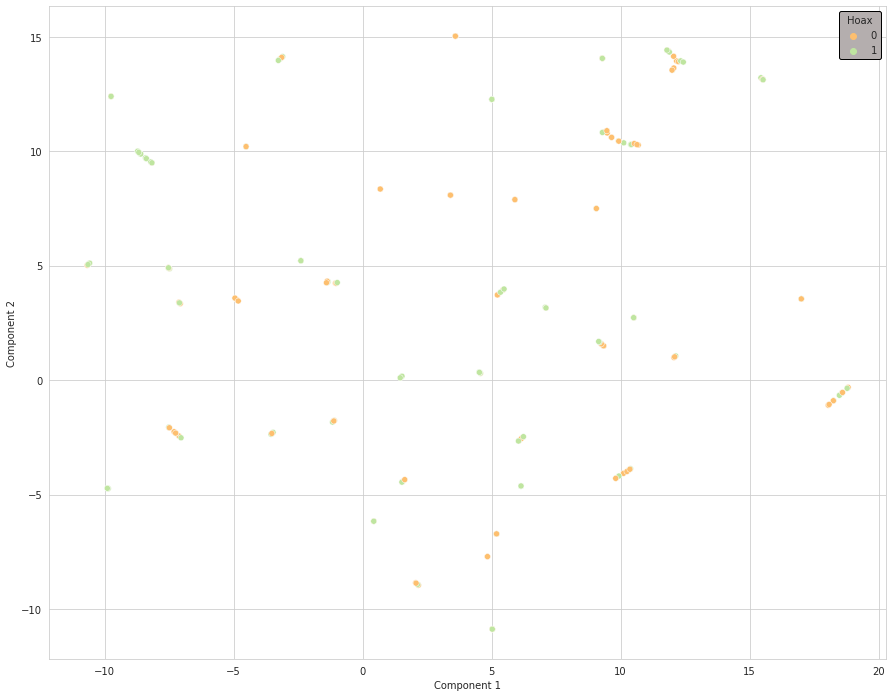

n_neighbors:2, min_dist:0.1


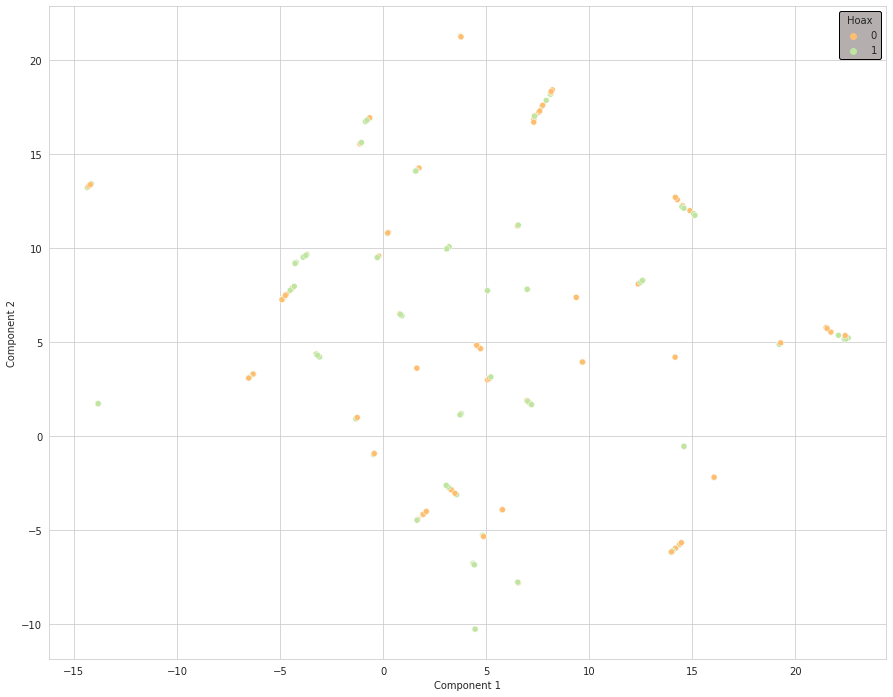

/home/jhuertas/.local/lib/python3.8/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


n_neighbors:2, min_dist:0.25


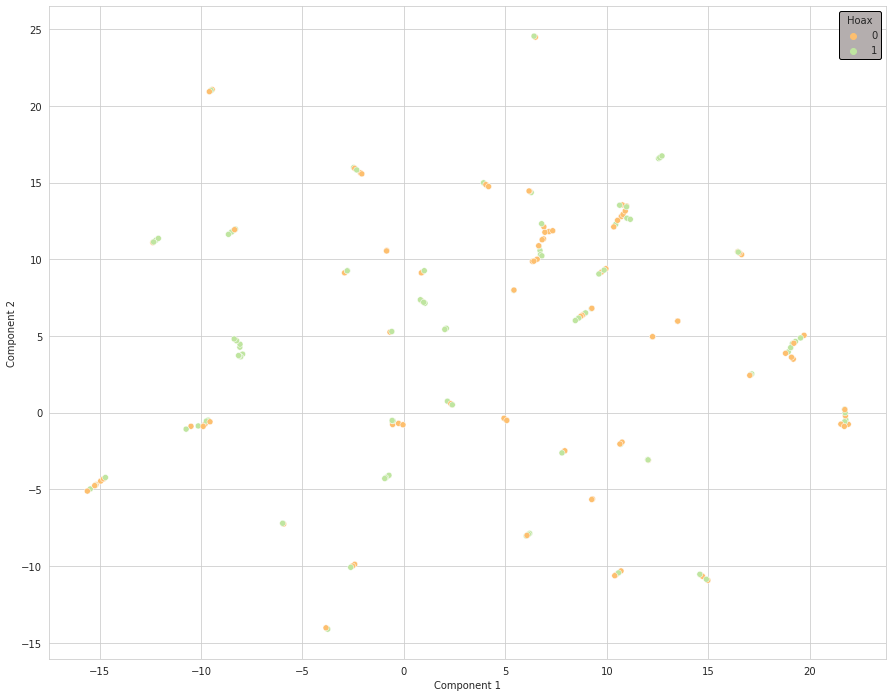

n_neighbors:2, min_dist:0.5


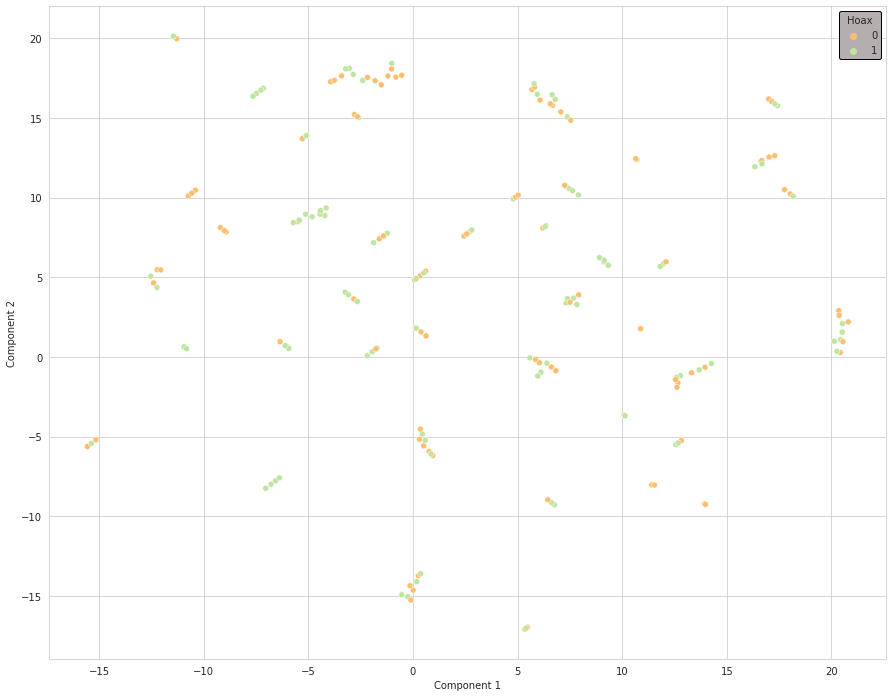

n_neighbors:2, min_dist:0.75


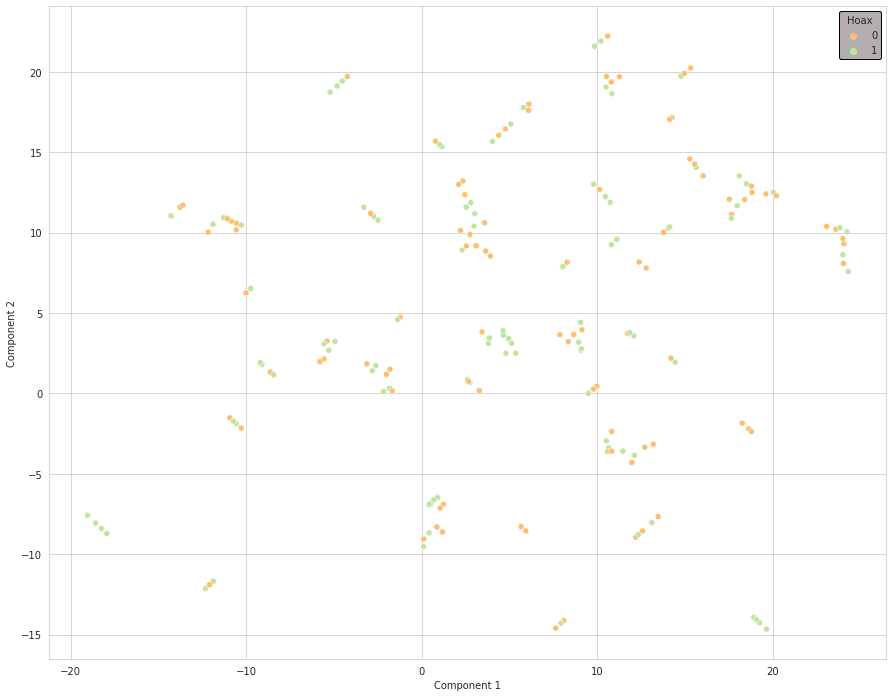

n_neighbors:2, min_dist:0.9


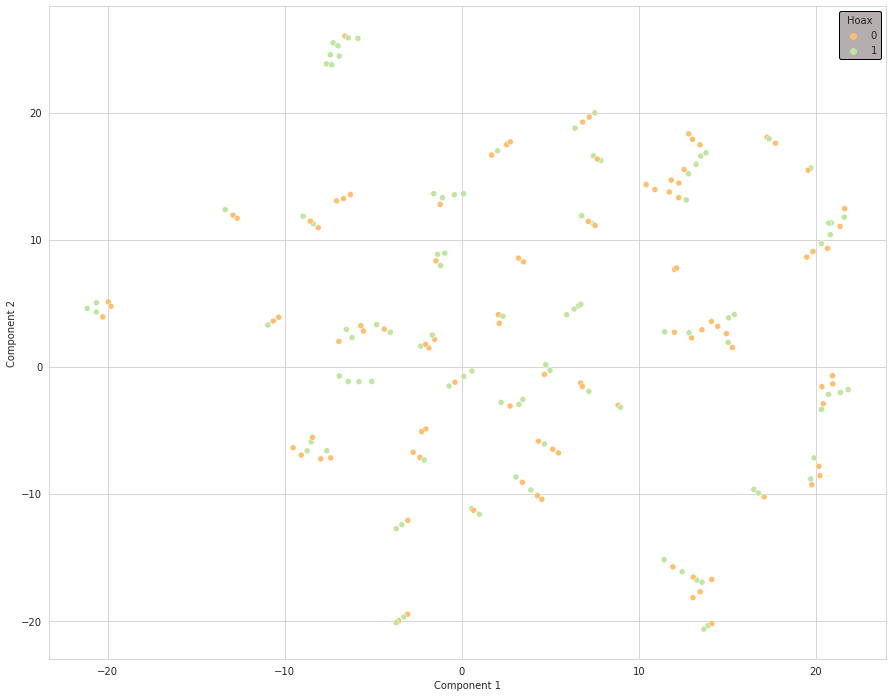

n_neighbors:2, min_dist:0.99


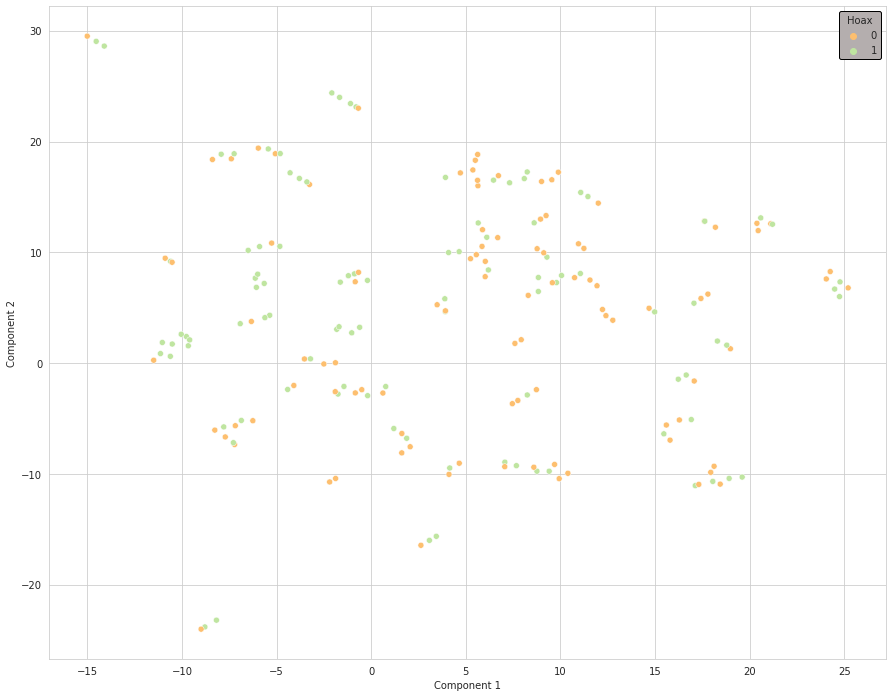

n_neighbors:5, min_dist:0.01


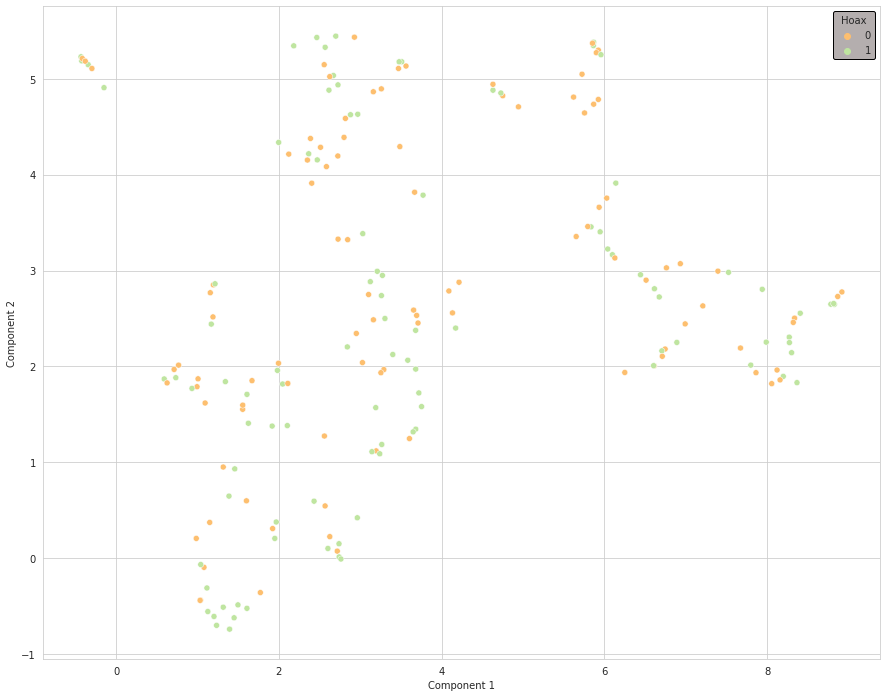

n_neighbors:5, min_dist:0.1


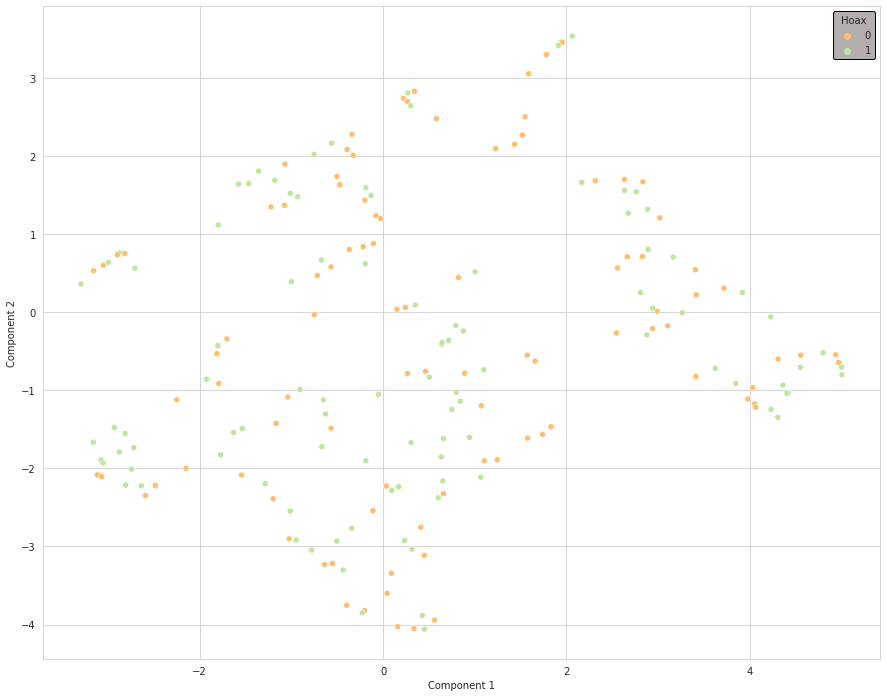

n_neighbors:5, min_dist:0.25


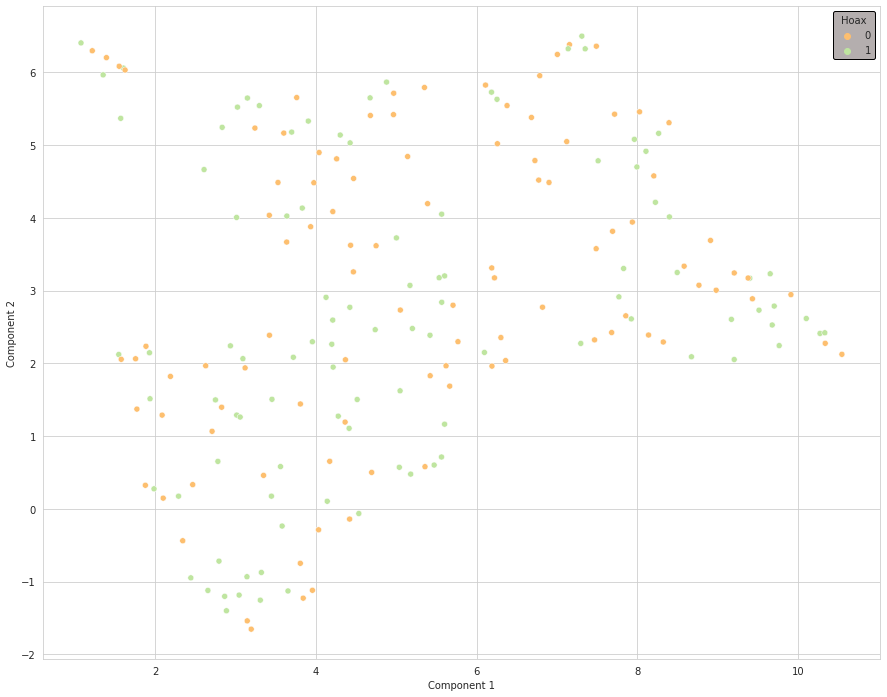

n_neighbors:5, min_dist:0.5


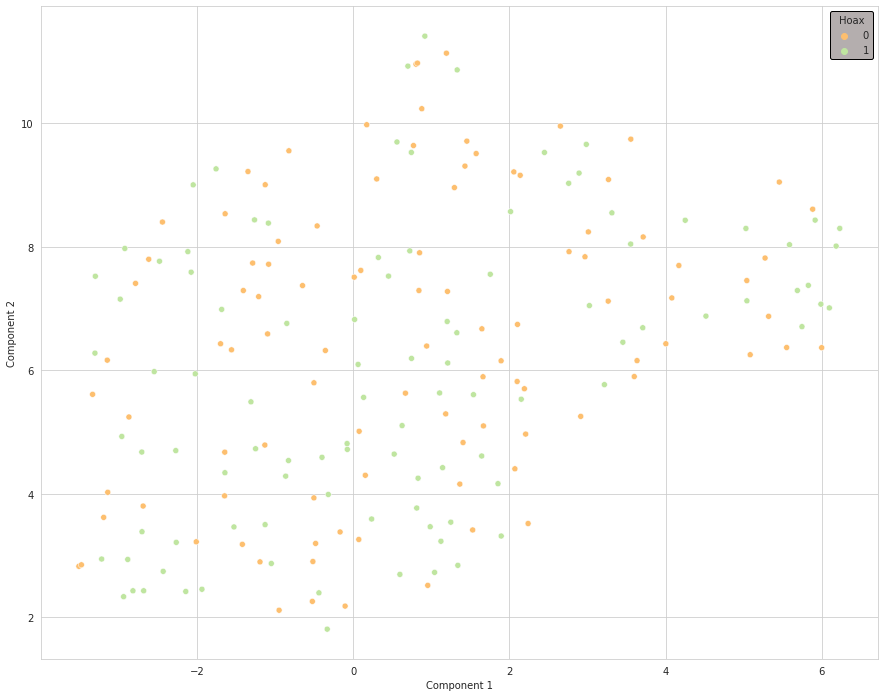

n_neighbors:5, min_dist:0.75


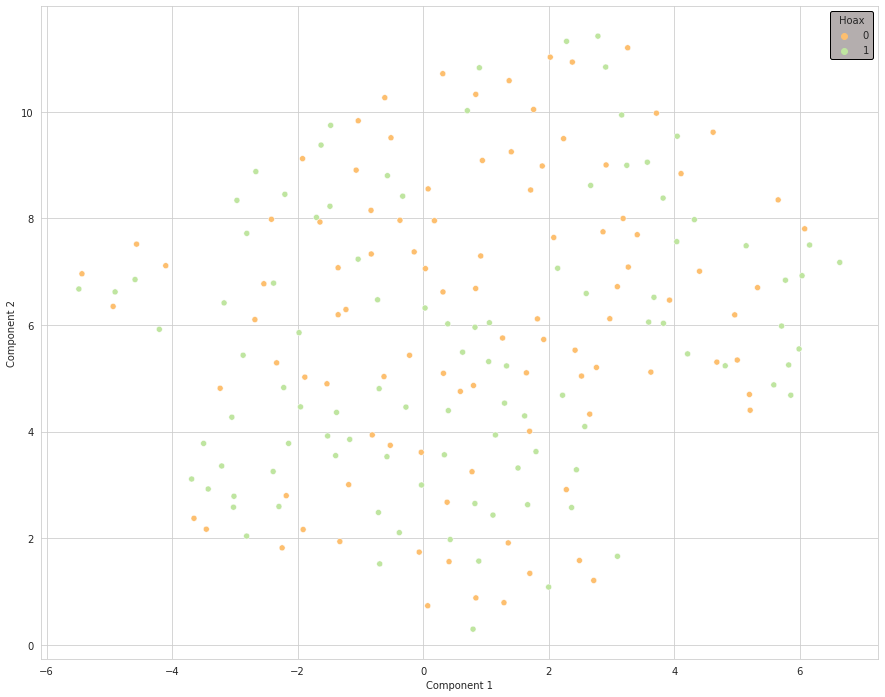

n_neighbors:5, min_dist:0.9


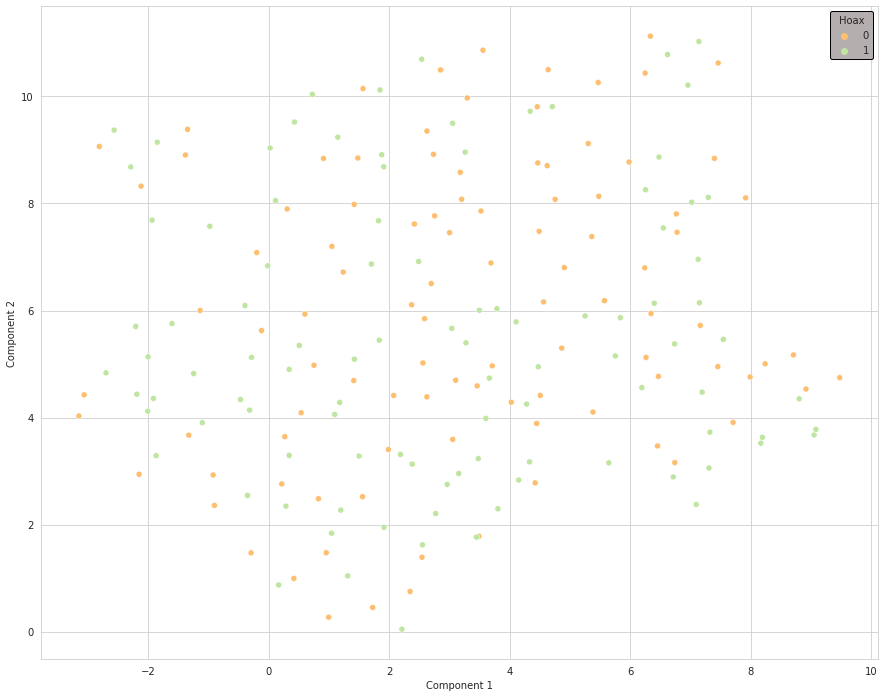

n_neighbors:5, min_dist:0.99


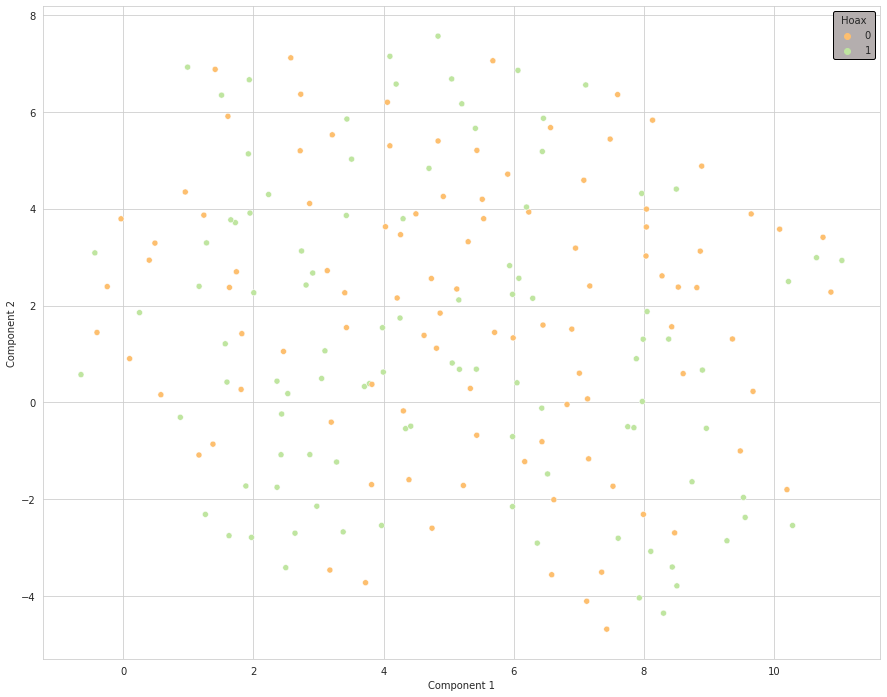

n_neighbors:10, min_dist:0.01


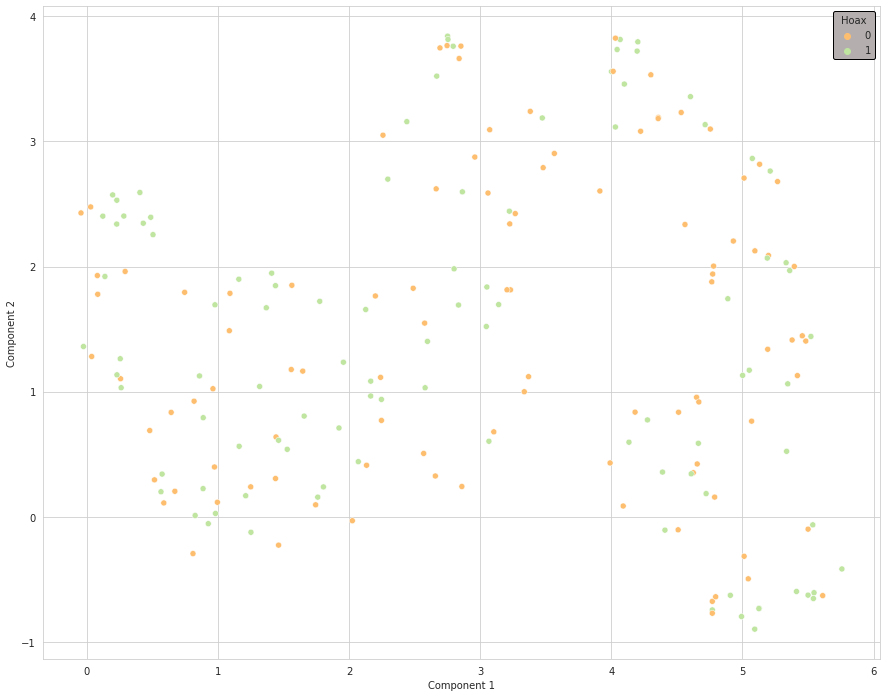

n_neighbors:10, min_dist:0.1


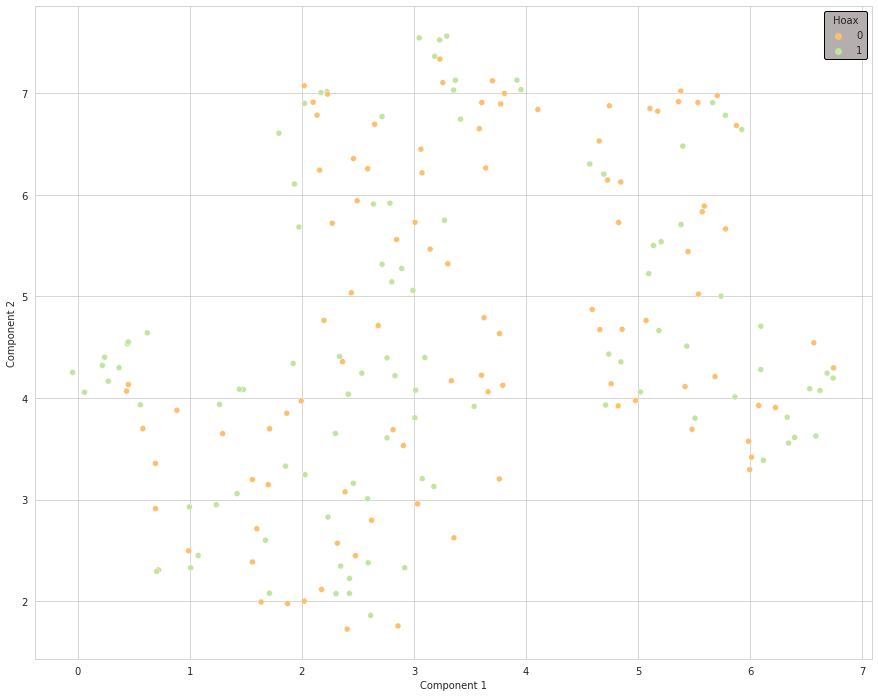

n_neighbors:10, min_dist:0.25


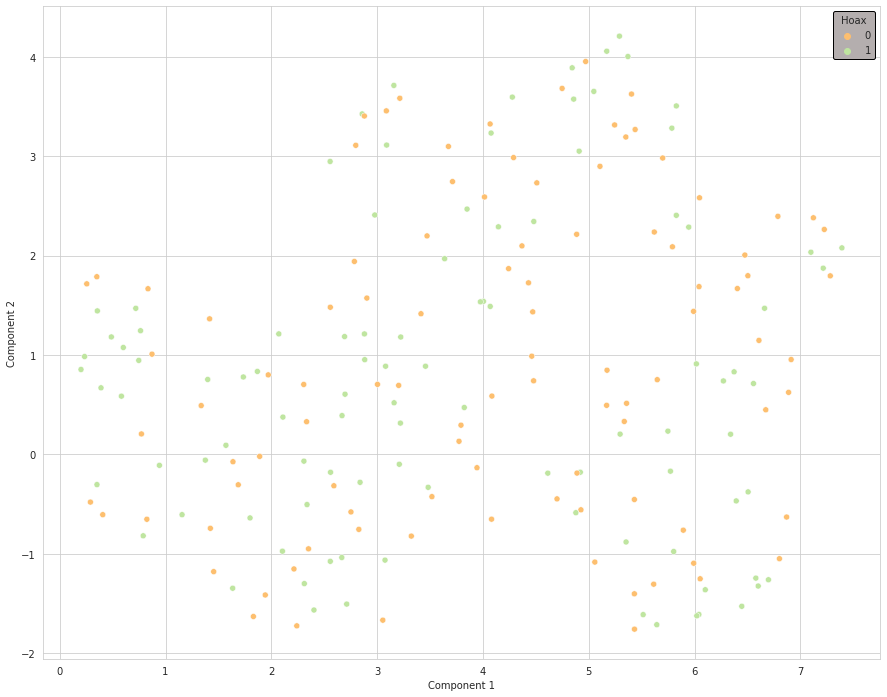

n_neighbors:10, min_dist:0.5


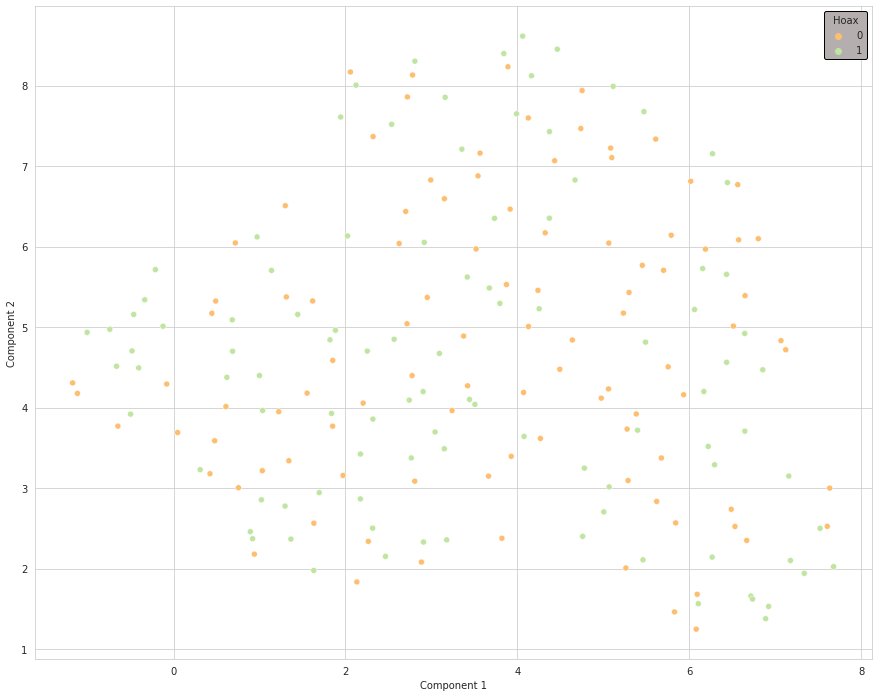

n_neighbors:10, min_dist:0.75


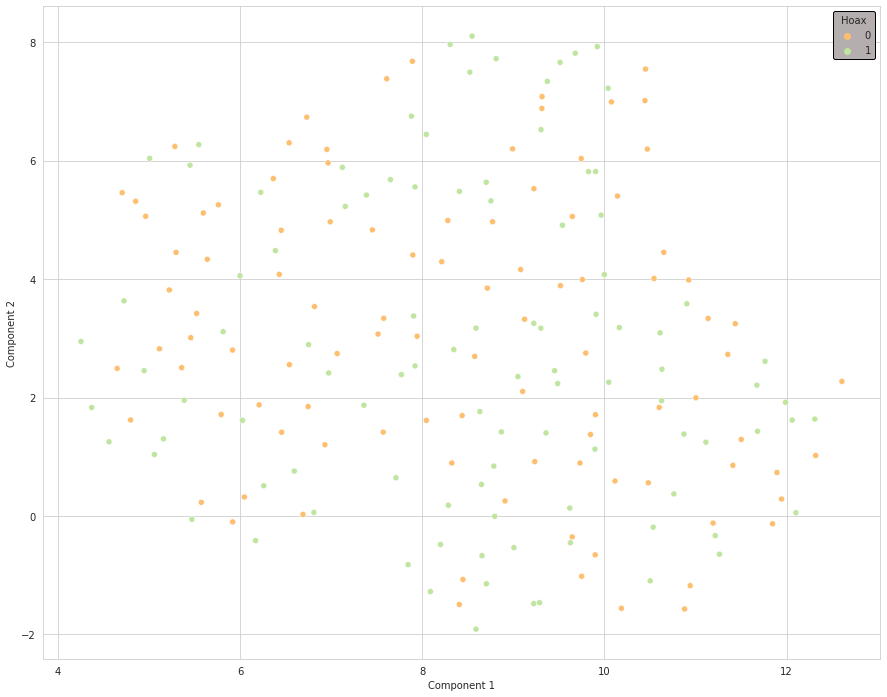

n_neighbors:10, min_dist:0.9


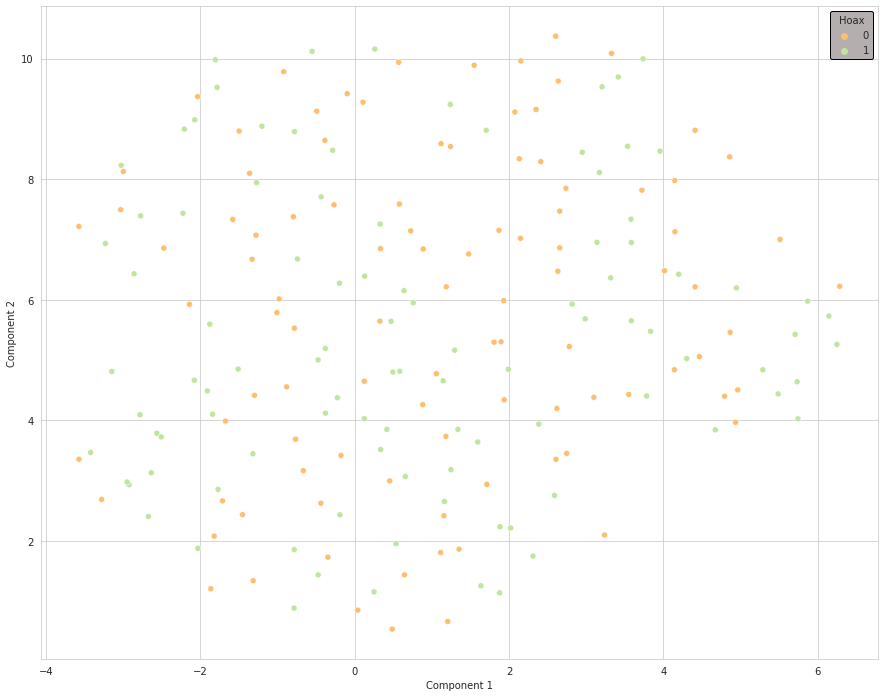

n_neighbors:10, min_dist:0.99


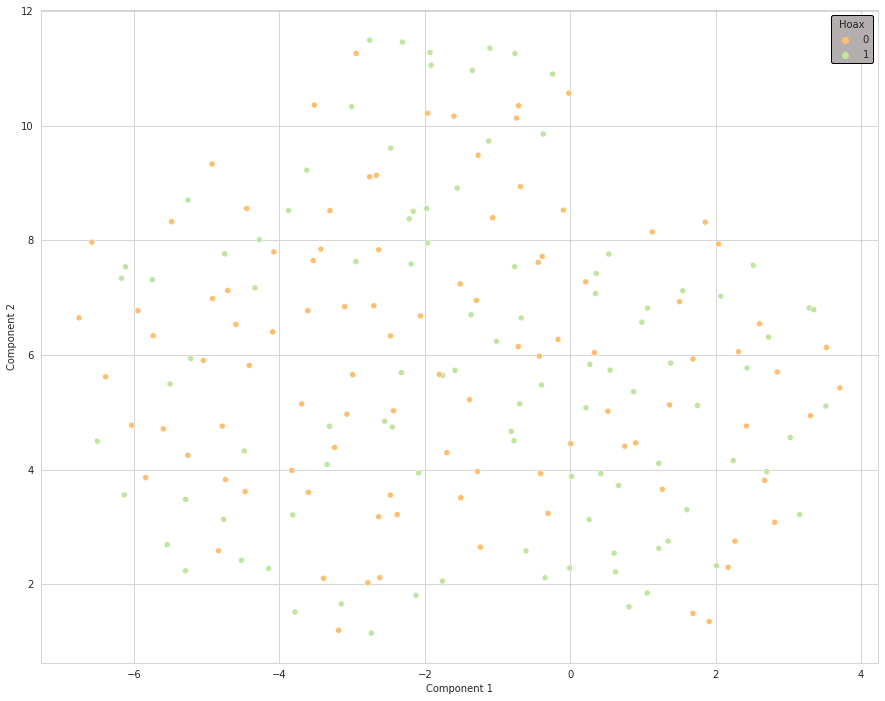

n_neighbors:20, min_dist:0.01


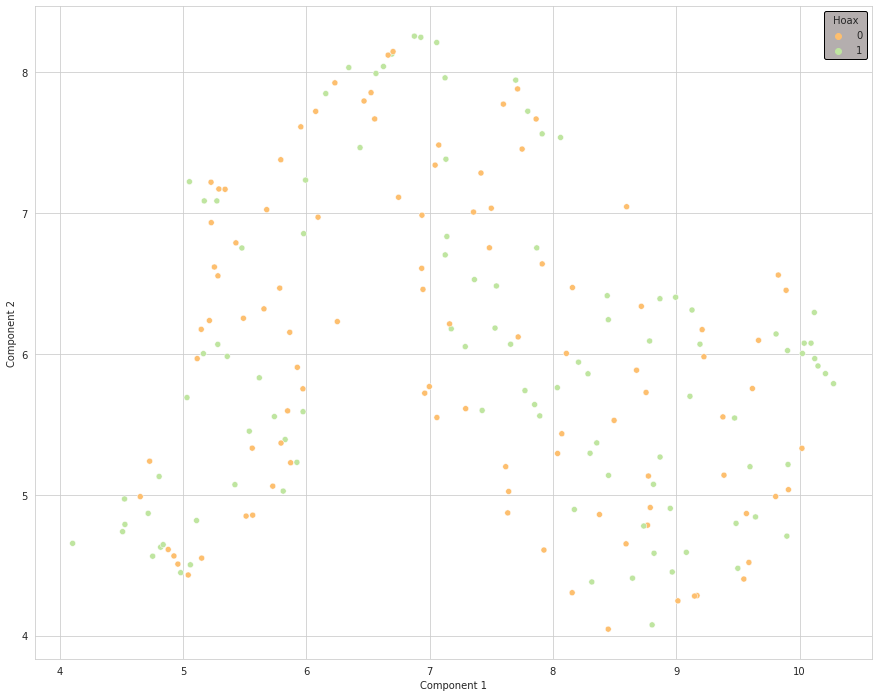

n_neighbors:20, min_dist:0.1


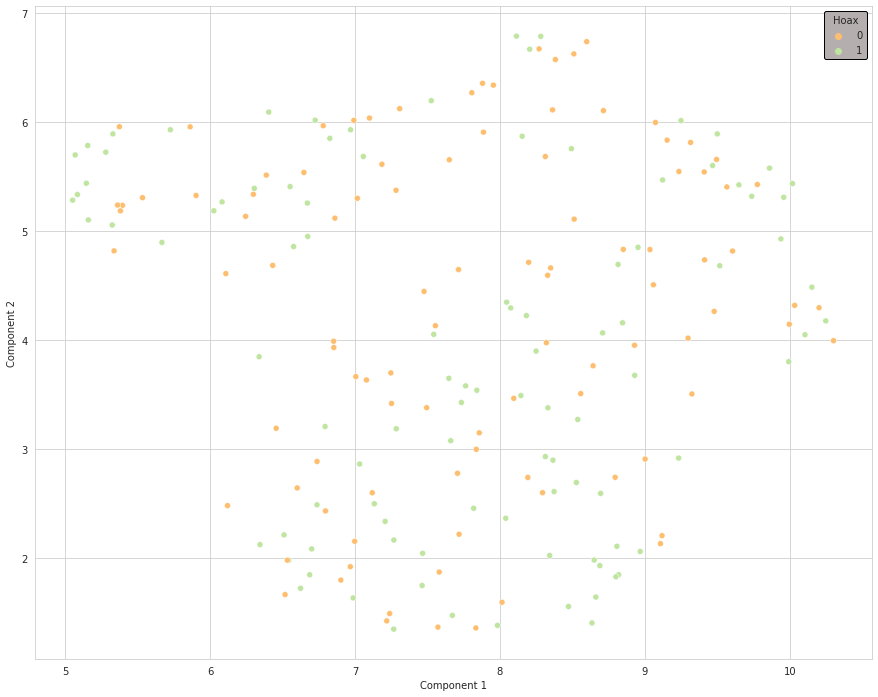

n_neighbors:20, min_dist:0.25


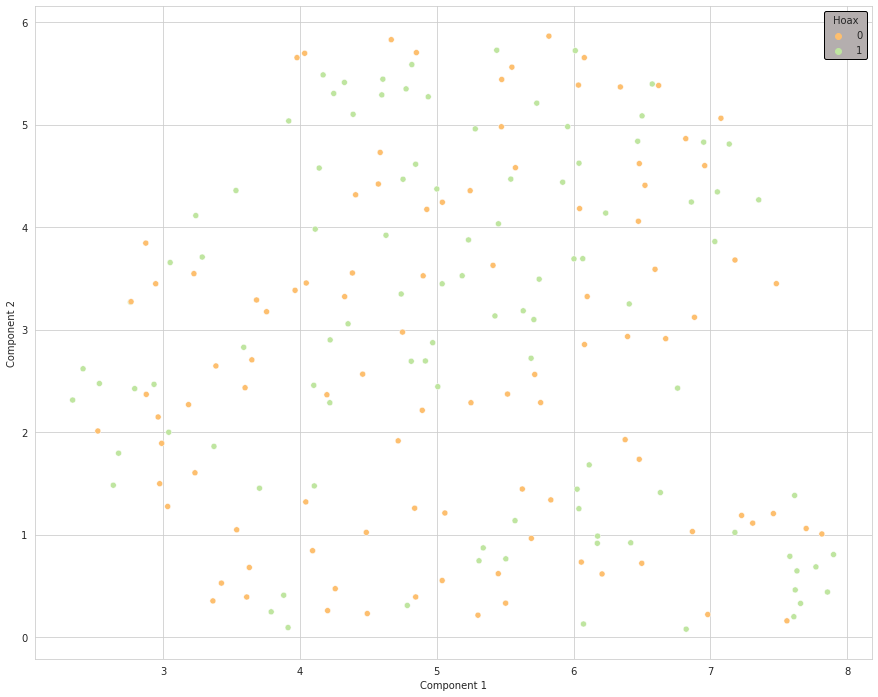

n_neighbors:20, min_dist:0.5


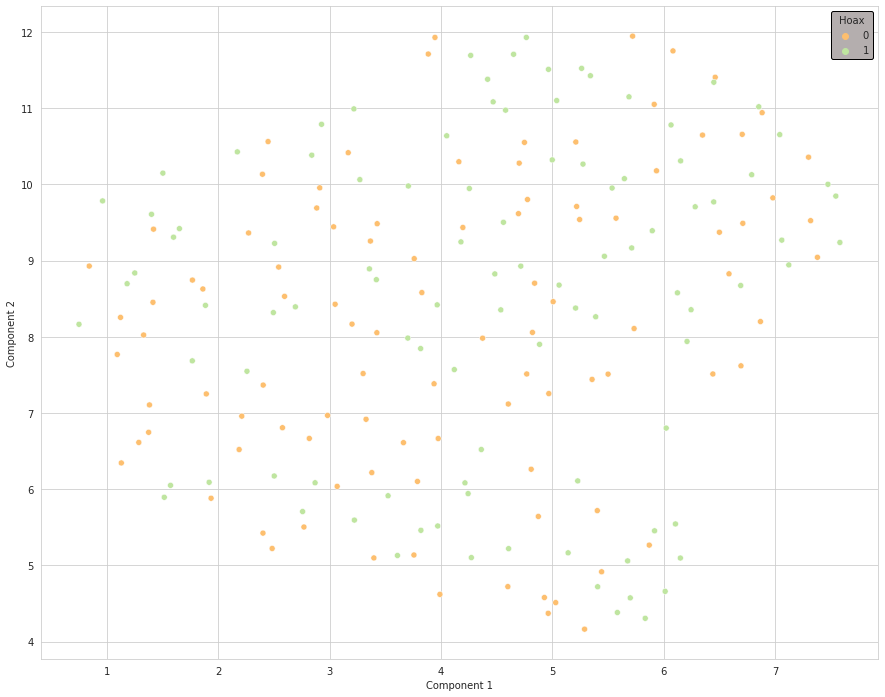

n_neighbors:20, min_dist:0.75


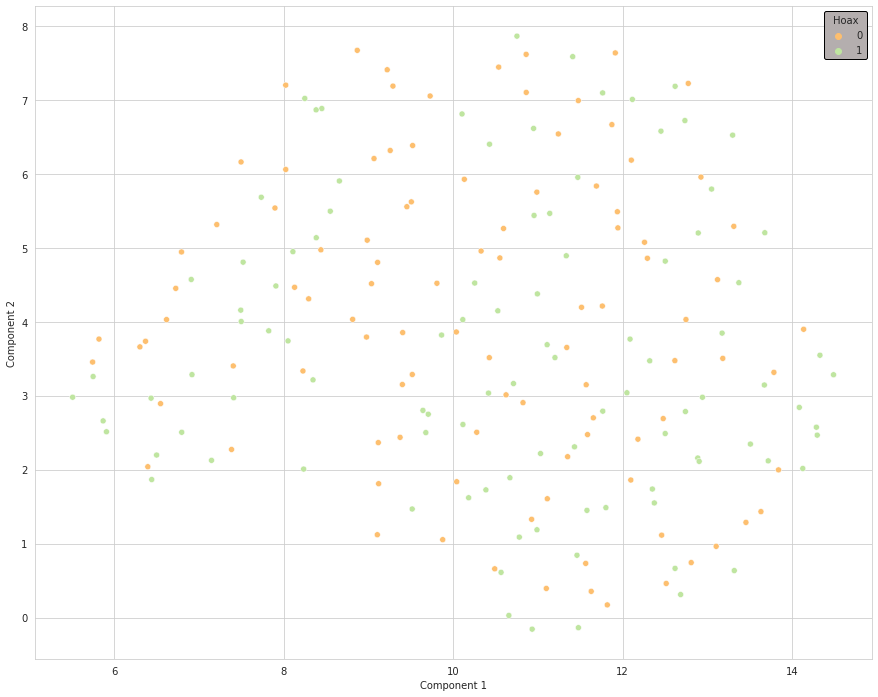

n_neighbors:20, min_dist:0.9


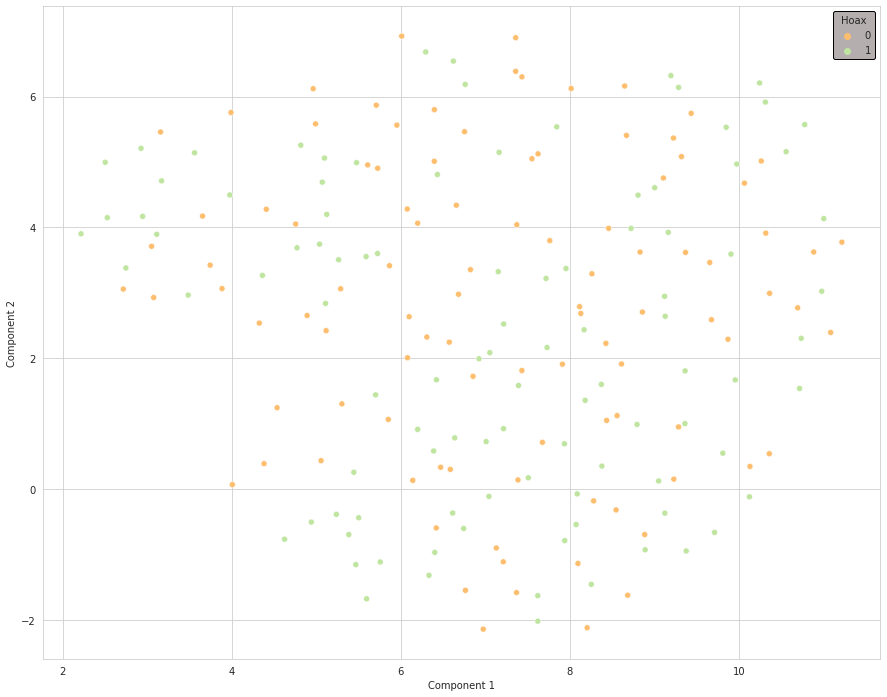

n_neighbors:20, min_dist:0.99


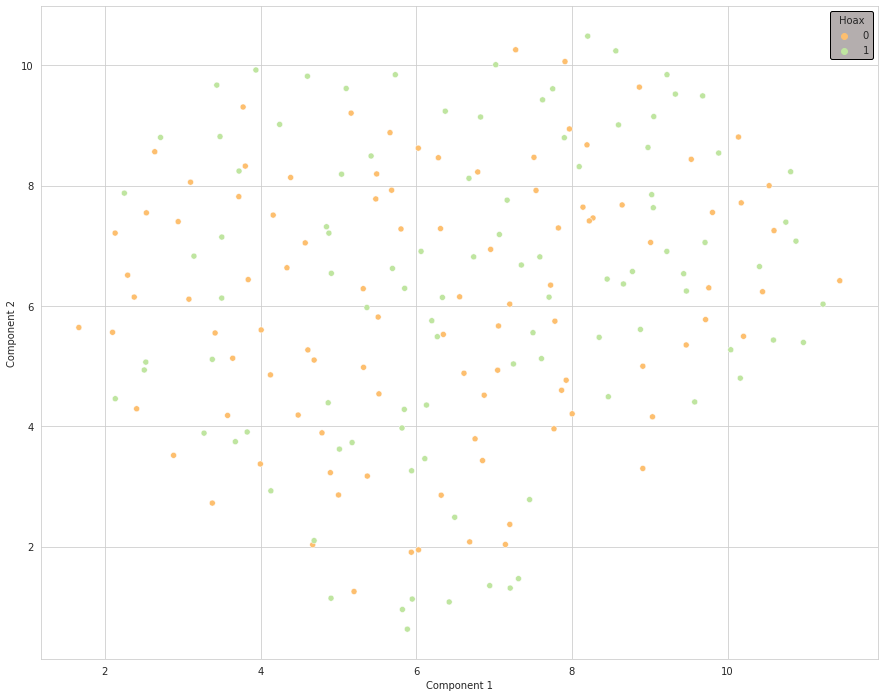

In [ ]:
neighbors = [2, 5, 10, 20, 50, 100]
min_dist = [.01, .1, .25, .5, .75, .9, .99]
params = [{'n_neighbors': nn, 'min_dist': md} for nn in neighbors for md in min_dist]

[make_plot(embeddings_test, **kwparams) for kwparams in params]

In [14]:
x = make_plot(embeddings_test, 5, .01)

n_neighbors:5, min_dist:0.01


In [27]:
x.iloc[10:20]

,umap_0,umap_1,label
user_id,,,
13e60f3210fa7bda9a427787f86cca12,12.750381,8.794642,0
14ea9d9e9ef139af4d95ea95faae4cf3,11.500046,8.039630,0
151eeeb1df123a7cb643c5e37e3b5096,13.606333,7.679985,1
15c60b79cc79e7bea8c69d70d90f4035,13.839576,8.284276,1
175e1df16d9199c091648ebde938fc84,12.831091,8.896047,0
183e5afe26378fc868028a3e64c7e059,12.297661,8.633939,0
18e0dfc8b56b122e88ffd753ca10537,14.296601,8.635938,1
1918c004fdeffa00edcb8b87e17738a1,11.132994,7.475088,0
1a864bebb8e61be6f677323da8e7c51b,14.311511,8.574201,0


In [22]:
y = test.groupby('user_id').apply(lambda x: '\n'.join(x.text.tolist()))
y

user_id
034rhbdu5dxg1p7ugwbdvo9oze9680kn    RT #USER#: Trump's legal team gave thousands i...
03qvyd6yvx7sc1ggl0x64h37qqk1ohyw    Kobe Bryant, NBA Superstar dies in copter cras...
08gb34g7782zv14rkom8xd44s31gsvdy    the Power of contemporary Art - International ...
090lrhtfoz1zm7quye676g4ktx597img    Former Wolves manager linked with fierce rival...
0pthhz6l89xsaxqkgneo9mlkixswsqc0    Asylum seekers worry new US policy will mean m...
                                                          ...                        
z98oow5h1kp1vffleg7k1f67s4jv9ibv    #USER# #USER# #USER# #USER# #USER# Thx Moni! E...
z9di4ct4f8vq0zo49f8nf8kcjd921jty    Oscars 2020 Voter Thinks Adam Sandler's 'Arrog...
zapxq6vcsq2m01gjwzhidnk633f4xn1n    Tinashe's Best Selfie Advice Will Get You All ...
zsnv7bpeyd0368gglbryiwwb5snfgt6s    Microsoft Giving Away a Jordan Proto-React Xbo...
zww9s2kf5f9oym6aehodkduzpjkxho7a    #USER# #USER# #USER# #USER# #USER# #USER# #USE...
Length: 400, dtype: object

In [23]:
y.loc['034rhbdu5dxg1p7ugwbdvo9oze9680kn'][:700]

"RT #USER#: Trump's legal team gave thousands in contributions to Republican senators ahead of the impeachment trial, according to da…\nRT #USER#: Classic #USER# let’s start the super bowl off with pro-war propaganda with former anti-war player/veran Pat Tillman. Dude lite…\nKeep this going to piss Trump off😂 #URL#\nRT #USER#: Nixon cost the Republicans 8 Senate and 40 House seats, this is far worse. Nixon's crimes were child's play compared to what T…\nRT #USER#: The fact that Republicans are so incredibly butt hurt by Nancy Pelosi ripping up some paper proves that Dems need to s…\nRT #USER#: President Ford pardoned his predecessor, Nixon, after he resigned amid the Watergate scandal.  “It could "

In [24]:
y.loc['03qvyd6yvx7sc1ggl0x64h37qqk1ohyw'][:700]

"Kobe Bryant, NBA Superstar dies in copter crash #URL#\nLong Lost Brother Miraculously Found ‘living In The Bush’ In South Africa! #URL#\nCrescent Varsity Restates Commitment to Academic Plus #URL# #URL#\n2020; A time to learn and deliver the economy\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 #URL# #URL#\nDelta Governor's Aide Put Smiles On Faces Of Primary School Pupils #URL# #URL#\nGov. Tambuwal Leads PDP Governors Forum #URL# #URL#\nFidelity Bank Appoints Isa Inuwa As Independent Non-executivedirector. #URL# #URL#\nForbes 2020 World’s Richest Rankings Released: Only 4 Nigerians Make Exclusive Billionaires List #URL#\nA law enforcement related commentary on mishandling death #URL# #URL#\nTraders Of The Onitsha Drug Market Must Be All"

In [26]:
y.loc['10ce3ae6fe01b1198fb1da990ff474f4'][:700]

'Nicolás Maduro amenaza con lanzar misiles contra España: "Vamos a desplegar todo nuestro sistema de misiles" #URL#\nUna muerte en un ambulatorio sin médicos cuestiona los recortes de la sanidad gallega #URL#\nHe publicado un vídeo nuevo en Facebook #URL#\nEl nieto de Franco afirma que los decretos son para temas urgentes, no para "tomarse la revancha 42 años después" #URL#\nEscándalo en Grecia: 30 miembros de una ONG son detenidos por tráfico de humanos #URL#\nEstos són más Listo que los políticos de España #URL#\nCojonudo es éste tío mirarlo asta el final #URL#\nVOX esta sacando toda la mierda de la Susana Díaz y todo lo que tenía en el cortijo viva el fontanero\n9 monjas quedan embarazadas en un m'

In [28]:
y.loc['1a864bebb8e61be6f677323da8e7c51b'][:700]

'(Incluye video) Cuando se terminaba el primer tiempo y el equipo comenzaba a generar dudas por la falta de... #URL#\nPubliqué una nueva foto en Facebook #URL#\n(Incluye galería) En medio de los viajes y empezando un mes que los tendrá ócupadísimos, los jugadores... #URL#\nTal como lo hizo Barovero, Rojas también manifestó que el grupo bancará al colombiano en caso de que decida... #URL#\nEn la antesala al partido de Primera entre River y San Lorenzo en el Nuevo Gasómetro, el conjunto de Zapata... #URL#\nSin Whatsapp hasta un buen tiempo...🤦🤦: me siento desactualizado\nPezzella aseguró que, más allá de su ingreso temporal por Maidana, se considera tan protagonista como cualquier... #URL#\nEl reconoc'